# Credit Card Fraudulent Transactions

### Works with imbalanced dataset from https://www.kaggle.com/mlg-ulb/creditcardfraud
### Can we use the available predictors to spot fraudulent transactions, getting as high a recall score as possible?

In [ ]:
# packages used in analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# read in data frame and print the head
credit_df = pd.read_csv("creditcard.csv")
credit_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
credit_df.shape

(284807, 31)

In [4]:
# Check for ay null values in table
credit_df.isnull().sum(axis=0)

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

## Exploratory data analysis (EDA)

Class populations:
0    284315
1       492
Name: Class, dtype: int64


Class proportions:
0    99.827251
1     0.172749
Name: Class, dtype: float64


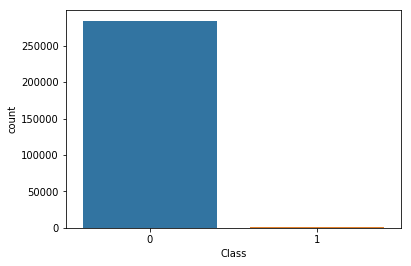

In [5]:
# let's see how imbalanced the dataset is on our response variable, Class
sns.countplot(data=credit_df, x='Class')
print("Class populations:")
print(credit_df['Class'].value_counts())
print("\n")
print("Class proportions:") 
print((credit_df['Class'].value_counts()/credit_df.shape[0])*100)

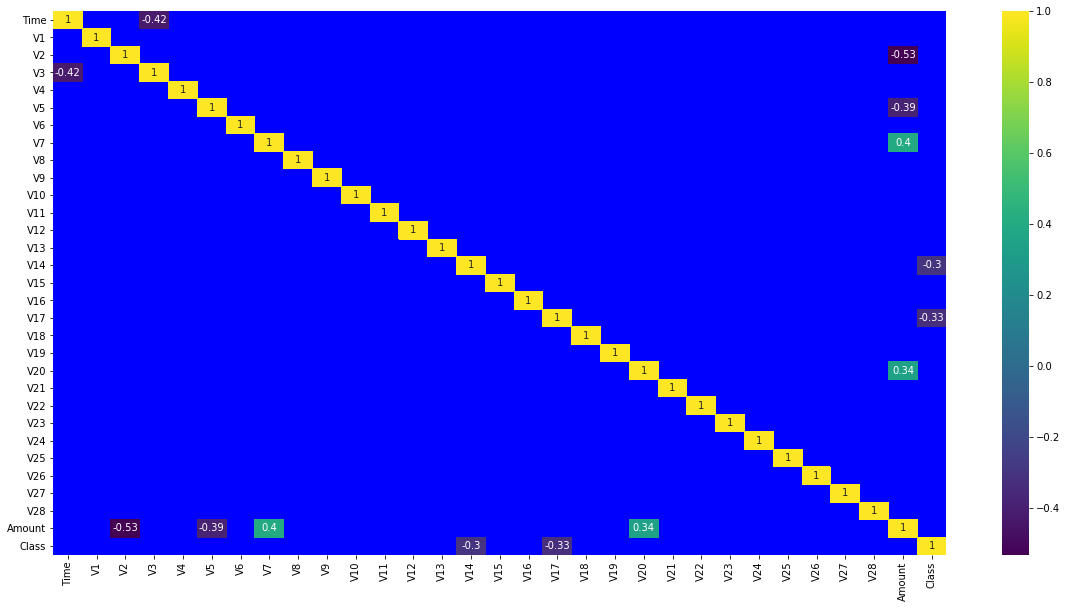

In [6]:
# Let's look at correlations between variables
corr = credit_df.corr()
plt.figure(figsize=(20,10))
g = sns.heatmap(corr, annot=True, mask=np.abs(corr)<0.3, cmap='viridis')
g.set_facecolor('blue')

# alternative using custom annot array
# annot_arr = corr[np.abs(corr) > 0.1]
# g = sns.heatmap(corr, annot=annot_arr, mask=pd.isnull(annot_arr), cmap='viridis')

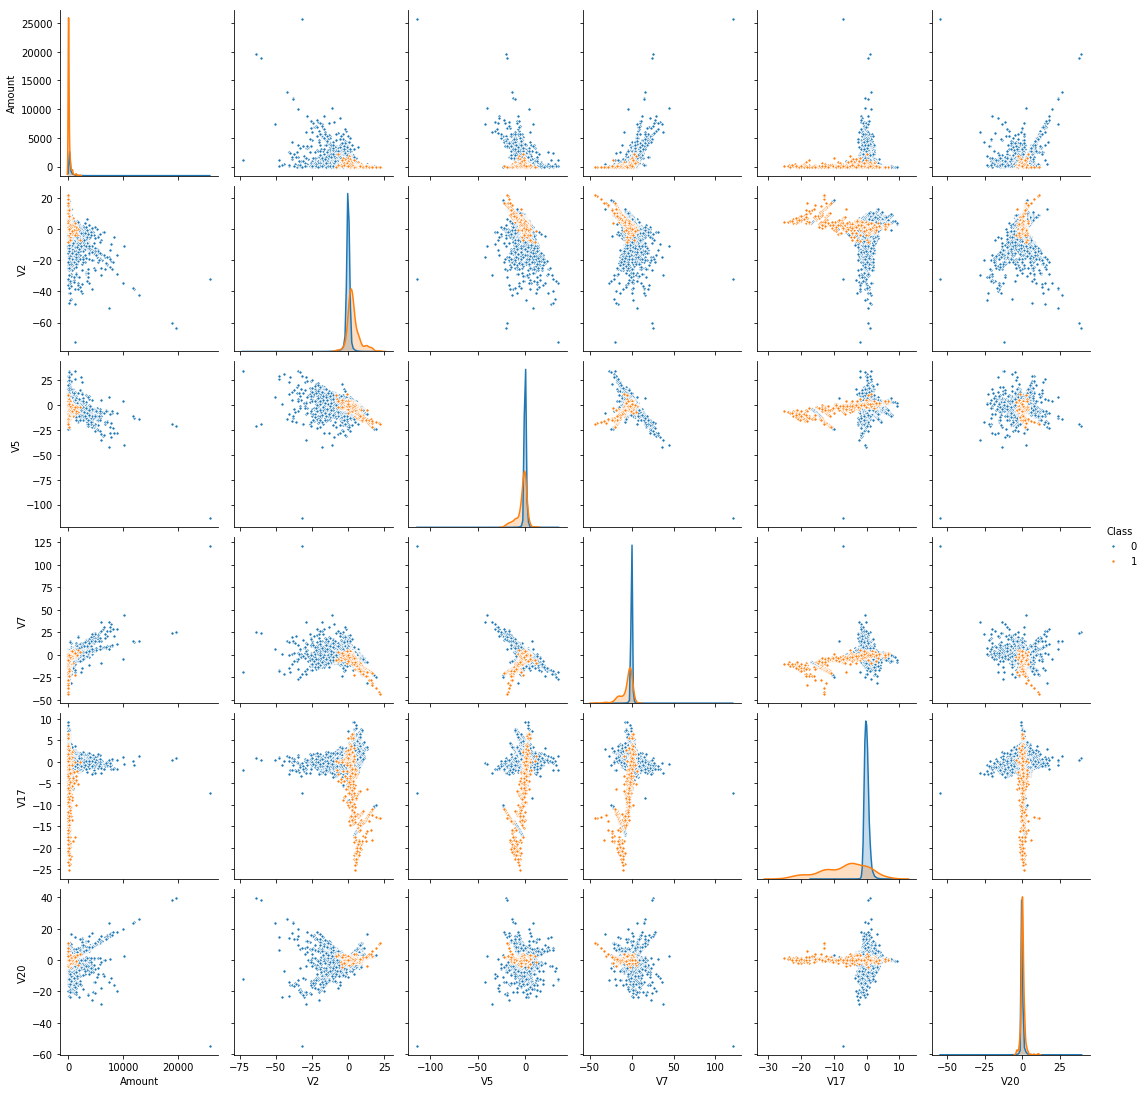

In [7]:
# take a look at some pair plots of the highest correlated variales
sns.pairplot(data=credit_df, hue='Class', x_vars=['Amount', 'V2', 'V5', 'V7', 'V17', 'V20'], y_vars=['Amount', 'V2', 'V5', 'V7', 'V17', 'V20'],
            plot_kws={'s':10}) # diag_kws={'bins':50}

Text(0, 0.5, 'Correlation with Class')

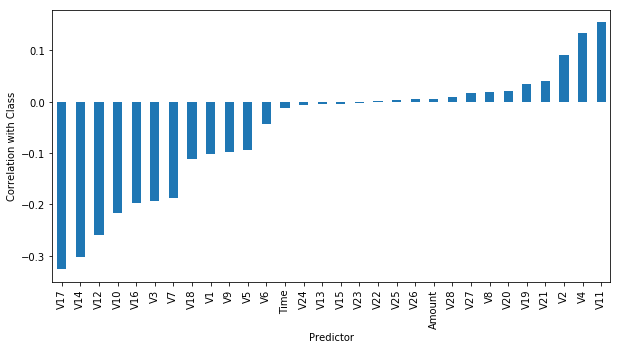

In [8]:
# how do the variables correlate with response
corr_response = credit_df.corr()['Class'].sort_values()[:-1].plot(kind='bar', figsize=(10,5))
plt.xlabel('Predictor')
plt.ylabel('Correlation with Class')

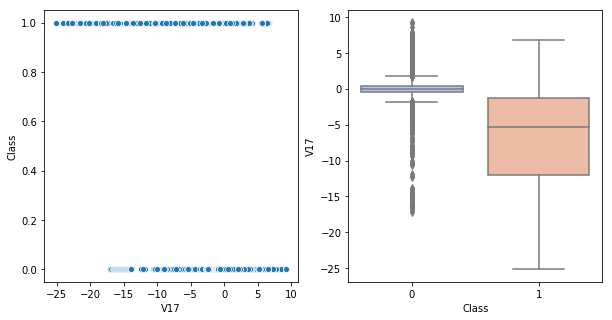

In [9]:
# Let's take a look at V17 vs response
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.scatterplot(data=credit_df, x='V17', y='Class', ax=ax[0])
sns.boxplot(data=credit_df, x='Class', y='V17', ax=ax[1], palette='coolwarm')

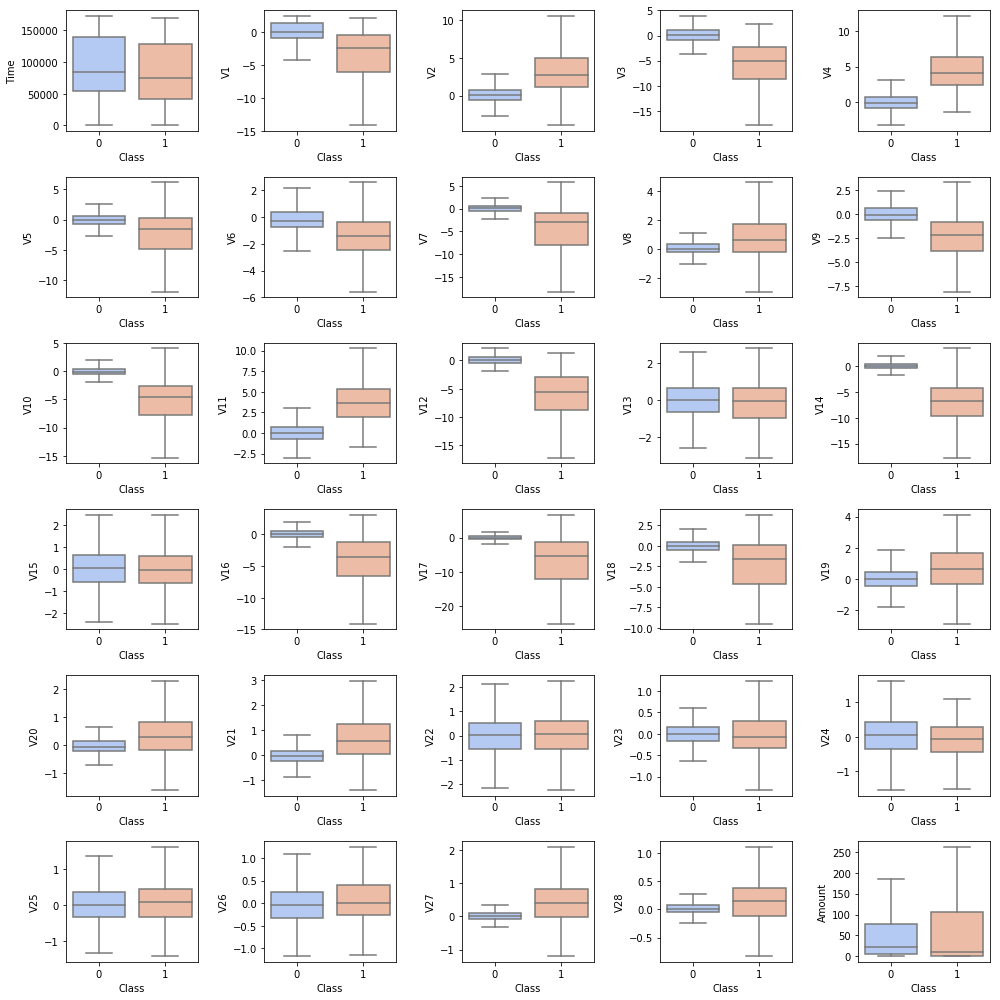

In [10]:
# Show the other responses
fig, ax = plt.subplots(6, 5, figsize=(14,14))

plot_n = 0
for i in range(6):
    for j in range(5):
        sns.boxplot(x='Class', y=credit_df.columns[plot_n], data=credit_df, showfliers=False,
                    ax=ax[i][j], palette='coolwarm')
        #sns.scatterplot(x=credit_df.columns[plot_n], y='Class', data=credit_df, ax=ax[i][j])
        plt.tight_layout()
        plot_n += 1

## Machine learning and variable selection

In [42]:
# Machine learning general packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

In [12]:
# First try simple logistic regression on all vars with unbalanced dataset - I expect this to be poor!
from sklearn.linear_model import LogisticRegression

In [13]:
# train_test_split step
X = credit_df.drop(['Class'], axis=1)
y = credit_df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

In [14]:
# fit logistic regression model
logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)
logmodel_predictions = logmodel.predict(X_test)
logmodel_predictions_prob = logmodel.predict_proba(X_test)

/home/robertv/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [15]:
# accuracy - not a good metric here:
accuracy = np.mean(logmodel_predictions == y_test)
print(accuracy)

0.9988828242203709


In [16]:
# why not? Because we have such an imbalanced dataset.
# Look at confusion matrix and classification report
print(confusion_matrix(y_true=y_test, y_pred=logmodel_predictions))
print(classification_report(y_true=y_test, y_pred=logmodel_predictions))

[[93797    33]
 [   72    85]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93830
           1       0.72      0.54      0.62       157

    accuracy                           1.00     93987
   macro avg       0.86      0.77      0.81     93987
weighted avg       1.00      1.00      1.00     93987



### So we have almost perfect identification for class 0, but it's very poor for class 1
In particular, recall for class 1 is 0.54.  This means that just 54% of the true frauds are correctly identified.  This is clearly not good enough.   

### Let's try balancing the dataset so there are approx equal numbers of default and no default cases 

In [17]:
# First try reducing the class 0 instances.  Do this by randomly selecting n_class = 1 instances from class 0
n_class1 = len(credit_df[credit_df['Class'] == 1])
sample_class0_credit_df = credit_df[credit_df['Class'] == 0].sample(n=n_class1, replace=False, random_state=101)
class1_credit_df = credit_df[credit_df['Class'] == 1]

In [18]:
# concatenate sampled class = 0 df with class = 1 df, and shuffle
small_balanced_credit_df = pd.concat([sample_class0_credit_df, class1_credit_df], axis=0).sample(frac=1, random_state=101).reset_index(drop=True)

In [19]:
# check now have randomly shuffled df with equal entries of class 1 and 0
print(len(small_balanced_credit_df[small_balanced_credit_df['Class'] == 1]))
print(len(small_balanced_credit_df[small_balanced_credit_df['Class'] == 0]))
small_balanced_credit_df.head(10)

492
492


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,57027.0,-2.335655,2.225380,-3.379450,2.178538,-3.568264,0.316814,-1.734948,1.449139,-1.980033,...,0.785540,0.297412,0.308536,-0.598416,-0.121850,-0.491018,0.701606,0.206966,444.17,1
1,125200.0,-0.769172,1.342212,-2.171454,-0.151513,-0.648374,-0.973504,-1.706658,0.313745,-1.982302,...,-0.036122,-0.753591,-0.047113,0.358493,-0.287407,0.476506,0.250531,0.250987,40.00,1
2,61571.0,1.290858,-0.410013,0.867951,-0.243360,-1.082847,-0.347126,-0.787556,0.081012,1.174355,...,0.013324,0.179744,-0.061696,-0.025827,0.192442,1.446274,-0.062826,0.002057,0.01,0
3,124970.0,1.718628,-0.538832,-0.681069,1.112363,-0.092306,0.530907,-0.385694,0.219596,0.660788,...,-0.128360,-0.601394,0.264292,0.133853,-0.406739,-1.012127,0.022561,-0.013865,123.00,0
4,47125.0,-2.206667,2.001343,0.001870,-0.252962,-0.783760,0.092856,-0.708638,1.068313,-0.039719,...,0.276661,0.515704,0.180610,-0.281968,-0.400024,0.183253,-1.074357,-0.271897,5.02,0
5,93853.0,-6.185857,7.102985,-13.030455,8.010823,-7.885237,-3.974550,-12.229608,4.971232,-4.248307,...,2.502772,0.481691,0.480958,0.360319,-0.293354,-0.199193,-0.203917,0.398927,44.90,1
6,2602.0,1.315933,0.383596,-0.030818,0.489348,0.100990,-0.575784,0.117157,-0.190518,-0.017784,...,-0.334617,-0.926221,0.017016,-0.476193,0.352236,0.144092,-0.019519,0.023839,1.79,0
7,8528.0,0.447396,2.481954,-5.660814,4.455923,-2.443780,-2.185040,-4.716143,1.249803,-0.718326,...,0.756053,0.140168,0.665411,0.131464,-1.908217,0.334808,0.748534,0.175414,1.00,1
8,42055.0,-2.560882,-5.927086,-1.695830,2.453046,-1.887225,1.064688,2.295572,-0.217118,-0.316918,...,1.284837,-0.556149,-1.693063,-0.195983,-0.276801,-0.503648,-0.309137,0.336248,1900.35,0
9,151972.0,-6.618211,3.835943,-6.316453,1.844111,-2.476892,-1.886718,-3.817495,0.613470,-1.482121,...,1.636622,0.038727,0.278218,0.786670,0.063895,0.154707,-2.042403,1.405141,57.73,1


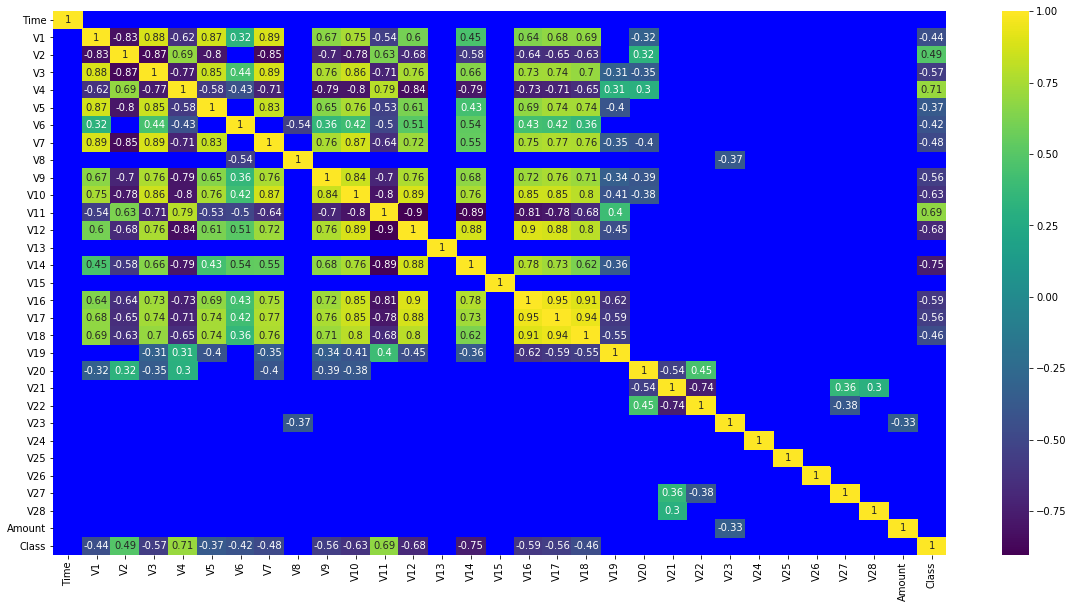

In [36]:
# Let's look at correlations in this reduced dataset between the variables - better for balanced dataset
corr_small_balanced = small_balanced_credit_df.corr()
plt.figure(figsize=(20,10))
g = sns.heatmap(corr_small_balanced, annot=True, mask=np.abs(corr_small_balanced)<0.3, cmap='viridis')
g.set_facecolor('blue')

In [20]:
# try logistic model on this

# train_test_split step
X_small_balanced = small_balanced_credit_df.drop(['Class'], axis=1)
y_small_balanced = small_balanced_credit_df['Class']
X_small_balanced_train, X_small_balanced_test, y_small_balanced_train, y_small_balanced_test = \
    train_test_split(X_small_balanced, y_small_balanced, test_size=0.33, random_state=101)

# fit logistic regression model
logmodel_small_balanced = LogisticRegression()
logmodel_small_balanced.fit(X_small_balanced_train, y_small_balanced_train)
logmodel_small_balanced_predictions = logmodel_small_balanced.predict(X_small_balanced_test)
logmodel_small_balanced_predictions_prob = logmodel_small_balanced.predict_proba(X_small_balanced_test)

print(confusion_matrix(y_true=y_small_balanced_test, y_pred=logmodel_small_balanced_predictions))
print(classification_report(y_true=y_small_balanced_test, y_pred=logmodel_small_balanced_predictions))

[[159   4]
 [ 15 147]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       163
           1       0.97      0.91      0.94       162

    accuracy                           0.94       325
   macro avg       0.94      0.94      0.94       325
weighted avg       0.94      0.94      0.94       325



/home/robertv/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Precision and recall now much better but  we have far fewer entries now.
### Is there a way to instead artificially increase the class = 1 entries?
Try SMOTE to oversample. SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbors for that example are found (typically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space.

In [21]:
from imblearn.over_sampling import SMOTE

In [114]:
# must just do on training set, as don't want to add new values to test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

# Need to scale amount and time (other vars already scaled as principal components) so smote resampling works
# NB smote uses k nearest neighbours so if don't scale time and amount, will put way too much precedence on these two vars compared with others


std_scaler = StandardScaler()
X_train_to_scale = X_train[['Time', 'Amount']]
X_test_to_scale = X_test[['Time', 'Amount']]

# IN BELOW LINES, MUST SET INDEX AGAIN AS STD SCALING REMOVES IT AND THEN WHEN RECREATE DF GET INDEX = 0,1,2,3, ...
# NEEDED AS ELSE PD.CONCAT WON'T WORK WHEN COMBINE X_TRAIN AND X_TRAIN_SCALED
X_train_scaled = pd.DataFrame(std_scaler.fit_transform(X_train_to_scale), columns=['Time', 'Amount'], index=X_train_to_scale.index)
X_test_scaled = pd.DataFrame(std_scaler.transform(X_test_to_scale), columns=['Time', 'Amount'], index=X_test_to_scale.index)
X_train = X_train.drop(['Time', 'Amount'], axis=1) # could set inplace=True instead  of assignment but get SETTINGWITHCOPYWARNING message
X_test = X_test.drop(['Time', 'Amount'], axis=1)
X_train = pd.concat([X_train, X_train_scaled], axis=1)
X_test = pd.concat([X_test, X_test_scaled], axis=1)

# COULD USE COLUMNTRANSFORMER BUT DOESN'T KEEP COL ORDERING - PUTS TIME AND AMOUNT AS FIRST TWO COLS:

#ct = ColumnTransformer([
#    ('std_scaler', StandardScaler(), ['Time', 'Amount'])
#], remainder='passthrough')
# fit to training data and scale it
#X_train = pd.DataFrame(ct.fit_transform(X_train), columns=X_train.columns)
#print(ct.get_feature_names())
#
# also scale test data but by the fitting params from training data to prevent data leakage
#X_test = pd.DataFrame(ct.transform(X_test), columns=X_test.columns)


# COULD SCALE COLS DIRECTLY BUT GET SETTINGWITHCOPYWARNING MESSAGES (ACTUALLY BENIGN HERE):

#std_scaler = StandardScaler()
#X_train[['Time', 'Amount']] = std_scaler.fit_transform(X_train[['Time', 'Amount']])
#X_train.loc[:,['Time', 'Amount']] = std_scaler.fit_transform(X_train[['Time', 'Amount']]) # ALTERNATIVE
#X_test[['Time', 'Amount']] = std_scaler.transform(X_test[['Time', 'Amount']])

print("Sanity check: Training set time and Amount std = ", X_train['Time'].std(), X_train['Amount'].std())
print("Sanity check: Test set time and Amount std = ", X_test['Time'].std(), X_test['Amount'].std())

# Now perform SMOTE on training set only
print("\nBEFORE SMOTE:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("Counts of class = 0:", np.sum(y_train==0))
print("Counts of class = 1:", np.sum(y_train==1))
smote = SMOTE(random_state=102)
X_smote_balanced_train, y_smote_balanced_train = smote.fit_sample(X_train, y_train)
X_smote_balanced_train = pd.DataFrame(X_smote_balanced_train, columns=X_train.columns)
print("\nAFTER SMOTE:")
print("X_smote_balanced_train shape:", X_smote_balanced_train.shape)
print("y_smote_balanced_train shape:", y_smote_balanced_train.shape)
print("Counts of class = 0:", np.sum(y_smote_balanced_train==0))
print("Counts of class = 1:", np.sum(y_smote_balanced_train==1))




Sanity check: Training set time and Amount std =  1.000002620280709 1.0000026202809114
Sanity check: Test set time and Amount std =  1.0003808620660077 1.0655325275132288

BEFORE SMOTE:
X_train shape: (190820, 30)
y_train shape: (190820,)
Counts of class = 0: 190485
Counts of class = 1: 335

AFTER SMOTE:
X_smote_balanced_train shape: (380970, 30)
y_smote_balanced_train shape: (380970,)
Counts of class = 0: 190485
Counts of class = 1: 190485


In [115]:
X_smote_balanced_train.head(10)
X_train_scaled.head()

,Time,Amount
50093,-1.063411,-0.289802
198744,0.795982,0.208983
35358,-1.195208,-0.258501
174063,0.566822,-0.307537
181587,0.636048,-0.258501


In [116]:
X_test.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Time,Amount
148943,-0.163337,1.512098,1.217663,2.825107,1.241397,-0.139000,1.425058,-0.428575,-0.546872,0.552275,...,0.062645,0.466575,-0.352740,-0.189612,0.372810,0.083304,-0.227115,-0.226318,-0.094605,-0.239581
110204,-0.866219,0.804735,1.805019,-0.533586,0.619282,-0.735604,0.837338,-0.111872,-0.725186,-0.849329,...,-0.201301,-0.738694,-0.179406,-0.108885,0.326540,0.047763,-0.019130,0.063679,-0.486794,-0.291274
120616,-2.155271,-0.175687,-0.364020,-1.743619,-2.893340,1.043236,1.817242,0.815885,0.832096,-2.098796,...,0.163686,0.481984,0.444372,-0.327187,0.078171,-0.780713,0.321325,-0.201845,-0.398972,1.913788
5861,-0.339932,1.380201,1.072837,1.332428,-0.419216,-1.053882,0.412905,0.080688,0.386621,-0.785161,...,0.081392,0.415919,0.054285,0.893219,-0.185338,-0.403577,-0.069670,-0.015613,-1.862890,-0.244198
201551,-1.161314,-0.287604,1.415444,-0.396877,0.695260,5.645620,-1.924195,2.079636,-0.108793,-0.096161,...,-0.212369,0.130911,-0.211139,0.693450,0.549518,-0.129519,0.345588,0.076093,0.823424,-0.156341


In [117]:
# try logistic regression on this
logmodel_smote_balanced = LogisticRegression()
logmodel_smote_balanced.fit(X_smote_balanced_train, y_smote_balanced_train)
logmodel_smote_balanced_predictions = logmodel_smote_balanced.predict(X_test) # Note using unbalanced test set
logmodel_smote_balanced_predictions_prob = logmodel_smote_balanced.predict_proba(X_test)

print(confusion_matrix(y_true=y_test, y_pred=logmodel_smote_balanced_predictions)) # Note using unbalanced test set
print(classification_report(y_true=y_test, y_pred=logmodel_smote_balanced_predictions))

print("model and actual negatives:", np.sum(logmodel_smote_balanced_predictions==0), np.sum(y_test==0))
print("model and actual positives:", np.sum(logmodel_smote_balanced_predictions==1), np.sum(y_test==1))


/home/robertv/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[91530  2300]
 [   13   144]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     93830
           1       0.06      0.92      0.11       157

    accuracy                           0.98     93987
   macro avg       0.53      0.95      0.55     93987
weighted avg       1.00      0.98      0.99     93987

model and actual negatives: 91543 93830
model and actual positives: 2444 157


In [118]:
print(logmodel_smote_balanced_predictions_prob[:,1])
print(y_test.values)

[0.26505882 0.02320989 0.0059551  ... 0.01536231 0.05807087 0.08095773]
[0 0 0 ... 0 0 0]


## Reference for confusion matrix and rates

              Model  
          |  0  |  1  |  
Actual

        0 |  TN | FP  |  
        1 |  FN | TP  |  


### Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
### Specificity or true negative rate
TNR = TN/(TN+FP) 
### Precision or positive predictive value
PPV = TP/(TP+FP)
### Negative predictive value
NPV = TN/(TN+FN)
### False positive rate or fall out
FPR = FP/(FP+TN)
### False negative rate
FNR = FN/(TP+FN)
### False discovery rate
FDR = FP/(TP+FP)

### Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

331 331 331


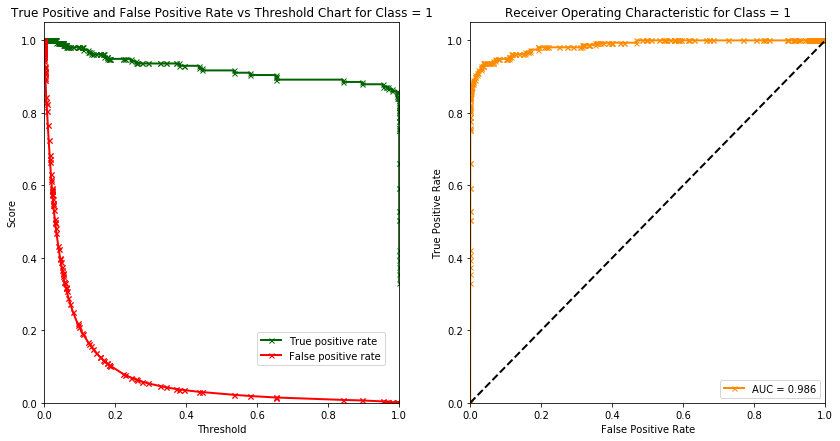

In [119]:
# plot true positives, false positives and ROC curve

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_true=y_test.values, y_score=logmodel_smote_balanced_predictions_prob[:,1])#, pos_label=2)
print(len(fpr), len(tpr), len(thresholds))
#print(fpr, tpr, thresholds)

# REMEMBER fpr = FP/(FP+TN)
# For threshold = 0.5: fpr = 2301/(2301+91529) = 0.0245
# So fpr is not a good metric with an unbalanced test set with lots of true negatives

roc_fig, roc_ax = plt.subplots(nrows=1, ncols=2, figsize=(14,7))

# true positives and false positives vs threshold
roc_ax[0].plot(thresholds, tpr, color='darkgreen', lw=2, marker='x', ms=5, label='True positive rate')
roc_ax[0].plot(thresholds, fpr, color='red', lw=2, marker='x', ms=5, label='False positive rate')
roc_ax[0].set_title("True Positive and False Positive Rate vs Threshold Chart for Class = 1")
roc_ax[0].set_xlim([0.0, 1.0])
roc_ax[0].set_ylim([0.0, 1.05])
roc_ax[0].set_xlabel('Threshold')
roc_ax[0].set_ylabel('Score')
roc_ax[0].legend(loc=(0.6, 0.1))

# roc curve
roc_auc = auc(fpr, tpr) # area under roc curve
roc_ax[1].plot(fpr, tpr, color='darkorange', lw=2, marker='x', ms=5, label='AUC = {0:.3f}'.format(roc_auc))
roc_ax[1].plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
roc_ax[1].set_title('Receiver Operating Characteristic for Class = 1')
roc_ax[1].set_xlim([0.0, 1.0])
roc_ax[1].set_ylim([0.0, 1.05])
roc_ax[1].set_xlabel('False Positive Rate')
roc_ax[1].set_ylabel('True Positive Rate')
roc_ax[1].legend(loc="lower right")


43959 43959 43958


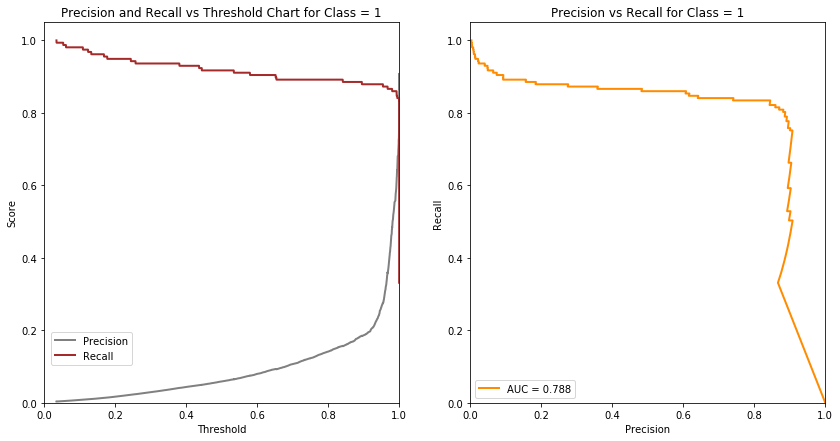

In [120]:
# plot precision and recall (a better metric as not using true negatives, of which there are many)

from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_true=y_test.values, probas_pred=logmodel_smote_balanced_predictions_prob[:,1]) 
print(len(precision), len(recall), len(thresholds))
#print(precision, recall, thresholds)

pr_fig, pr_ax = plt.subplots(nrows=1, ncols=2, figsize=(14,7))

# precision and recall vs threshold
pr_ax[0].plot(thresholds, precision[:-1], color='gray', lw=2, label='Precision')
pr_ax[0].plot(thresholds, recall[:-1], color='brown', lw=2, label='Recall')
pr_ax[0].set_title("Precision and Recall vs Threshold Chart for Class = 1")
pr_ax[0].set_xlim([0.0, 1.0])
pr_ax[0].set_ylim([0.0, 1.05])
pr_ax[0].set_xlabel('Threshold')
pr_ax[0].set_ylabel('Score')
pr_ax[0].legend(loc=(0.02, 0.1))

# precision-recall curve
pr_auc = auc(recall, precision) # area under pr curve
pr_ax[1].plot(precision, recall, color='darkorange', lw=2, label='AUC = {0:.3f}'.format(pr_auc))
pr_ax[1].set_title('Precision vs Recall for Class = 1')
pr_ax[1].set_xlim([0.0, 1.0])
pr_ax[1].set_ylim([0.0, 1.05])
pr_ax[1].set_xlabel('Precision')
pr_ax[1].set_ylabel('Recall')
pr_ax[1].legend(loc="lower left")


[[185764   4721]
 [ 15253 175232]]
              precision    recall  f1-score   support

           0       0.92      0.98      0.95    190485
           1       0.97      0.92      0.95    190485

    accuracy                           0.95    380970
   macro avg       0.95      0.95      0.95    380970
weighted avg       0.95      0.95      0.95    380970

34311 34311 34311
238644 238644 238643


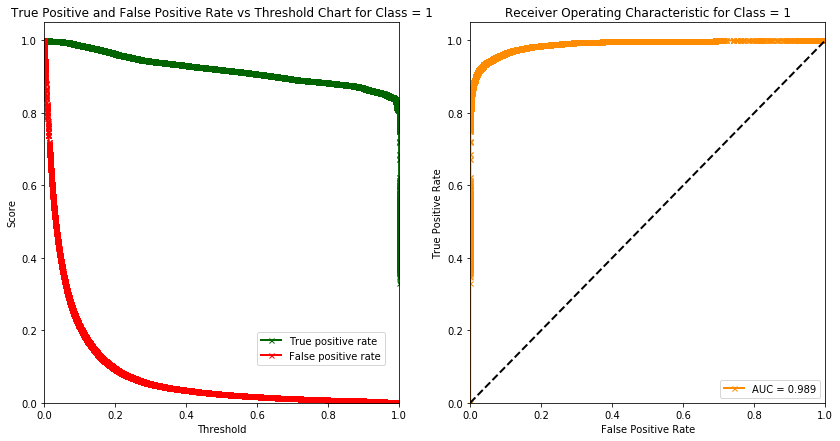

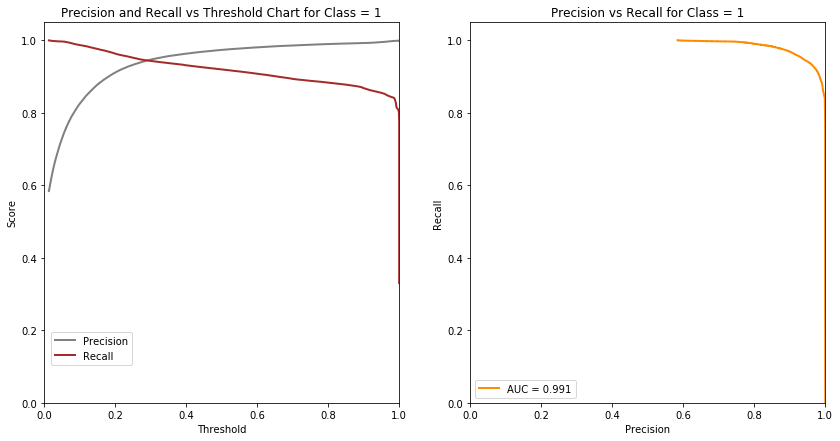

In [121]:
# Just to demonstrate how the curves vary with the training set
logmodel_smote_balanced_predictions_train = logmodel_smote_balanced.predict(X_smote_balanced_train)
logmodel_smote_balanced_predictions_prob_train = logmodel_smote_balanced.predict_proba(X_smote_balanced_train)

print(confusion_matrix(y_true=y_smote_balanced_train, y_pred=logmodel_smote_balanced_predictions_train))
print(classification_report(y_true=y_smote_balanced_train, y_pred=logmodel_smote_balanced_predictions_train))

fpr, tpr, thresholds = roc_curve(y_true=y_smote_balanced_train, y_score=logmodel_smote_balanced_predictions_prob_train[:,1])#, pos_label=2)
print(len(fpr), len(tpr), len(thresholds))
#print(fpr, tpr, thresholds)

# REMEMBER fpr = FP/(FP+TN)
# For threshold = 0.5: fpr = 2301/(2301+91529) = 0.0245
# So fpr is not a good metric with an unbalanced test set with lots of true negatives

roc_fig, roc_ax = plt.subplots(nrows=1, ncols=2, figsize=(14,7))

# true positives and false positives vs threshold
roc_ax[0].plot(thresholds, tpr, color='darkgreen', lw=2, marker='x', ms=5, label='True positive rate')
roc_ax[0].plot(thresholds, fpr, color='red', lw=2, marker='x', ms=5, label='False positive rate')
roc_ax[0].set_title("True Positive and False Positive Rate vs Threshold Chart for Class = 1")
roc_ax[0].set_xlim([0.0, 1.0])
roc_ax[0].set_ylim([0.0, 1.05])
roc_ax[0].set_xlabel('Threshold')
roc_ax[0].set_ylabel('Score')
roc_ax[0].legend(loc=(0.6, 0.1))

# roc curve
roc_auc = auc(fpr, tpr) # area under roc curve
roc_ax[1].plot(fpr, tpr, color='darkorange', lw=2, marker='x', ms=5, label='AUC = {0:.3f}'.format(roc_auc))
roc_ax[1].plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
roc_ax[1].set_title('Receiver Operating Characteristic for Class = 1')
roc_ax[1].set_xlim([0.0, 1.0])
roc_ax[1].set_ylim([0.0, 1.05])
roc_ax[1].set_xlabel('False Positive Rate')
roc_ax[1].set_ylabel('True Positive Rate')
roc_ax[1].legend(loc="lower right")

precision, recall, thresholds = precision_recall_curve(y_true=y_smote_balanced_train, probas_pred=logmodel_smote_balanced_predictions_prob_train[:,1]) 
print(len(precision), len(recall), len(thresholds))
#print(precision, recall, thresholds)

pr_fig, pr_ax = plt.subplots(nrows=1, ncols=2, figsize=(14,7))

# precision and recall vs threshold
pr_ax[0].plot(thresholds, precision[:-1], color='gray', lw=2, label='Precision')
pr_ax[0].plot(thresholds, recall[:-1], color='brown', lw=2, label='Recall')
pr_ax[0].set_title("Precision and Recall vs Threshold Chart for Class = 1")
pr_ax[0].set_xlim([0.0, 1.0])
pr_ax[0].set_ylim([0.0, 1.05])
pr_ax[0].set_xlabel('Threshold')
pr_ax[0].set_ylabel('Score')
pr_ax[0].legend(loc=(0.02, 0.1))

# precision-recall curve
pr_auc = auc(recall, precision) # area under pr curve
pr_ax[1].plot(precision, recall, color='darkorange', lw=2, label='AUC = {0:.3f}'.format(pr_auc))
pr_ax[1].set_title('Precision vs Recall for Class = 1')
pr_ax[1].set_xlim([0.0, 1.0])
pr_ax[1].set_ylim([0.0, 1.05])
pr_ax[1].set_xlabel('Precision')
pr_ax[1].set_ylabel('Recall')
pr_ax[1].legend(loc="lower left")


## Can we try other ML algorithms to improve the class = 1 precision?
Try a random forest

In [156]:
# Will want to do a grid search to determine the best number of trees and predictors used at each split

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from imblearn.pipeline import Pipeline # Note ordinary pipeline won't work with SMOTE

search_params = {
    'forest__n_estimators': [np.random.randint(100) for i in range(100)],
    'forest__max_depth': [1, 15, 30]
}

ct = ColumnTransformer([
    ('my_std_scaler', StandardScaler(), ['Time', 'Amount'])
], remainder='passthrough')

# whole lot needs to be in a pipeline to prevent data leakage.  Will use SMOTE again
# for each search param case, split up training data into five cross-vals.
# for each cross val, take the training part and std scale it and smote it, and then fit it.  
# Apply fit params from each of these to validation part of cross val.
# Take average score of the 5 cross-vals for each search.
# Pick highest scoring search
pipe = Pipeline([
    ('ct', ct),
    ('smote', SMOTE(random_state=102)),
    ('forest', RandomForestClassifier())
])

search = RandomizedSearchCV(pipe, search_params, cv=5, n_iter=20, random_state=101, verbose=4)
search.fit(X_train, y_train)
forest_predictions = search.predict(X_test) 
forest_predictions_prob = search.predict_proba(X_test)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] forest__n_estimators=79, forest__max_depth=15 ...................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  forest__n_estimators=79, forest__max_depth=15, score=0.999, total= 2.1min
[CV] forest__n_estimators=79, forest__max_depth=15 ...................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.1min remaining:    0.0s


[CV]  forest__n_estimators=79, forest__max_depth=15, score=0.999, total= 2.2min
[CV] forest__n_estimators=79, forest__max_depth=15 ...................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.3min remaining:    0.0s


[CV]  forest__n_estimators=79, forest__max_depth=15, score=0.999, total= 2.1min
[CV] forest__n_estimators=79, forest__max_depth=15 ...................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  6.5min remaining:    0.0s


[CV]  forest__n_estimators=79, forest__max_depth=15, score=0.999, total= 2.2min
[CV] forest__n_estimators=79, forest__max_depth=15 ...................
[CV]  forest__n_estimators=79, forest__max_depth=15, score=0.999, total= 2.2min
[CV] forest__n_estimators=51, forest__max_depth=30 ...................
[CV]  forest__n_estimators=51, forest__max_depth=30, score=0.999, total= 1.5min
[CV] forest__n_estimators=51, forest__max_depth=30 ...................
[CV]  forest__n_estimators=51, forest__max_depth=30, score=0.999, total= 1.6min
[CV] forest__n_estimators=51, forest__max_depth=30 ...................
[CV]  forest__n_estimators=51, forest__max_depth=30, score=1.000, total= 1.6min
[CV] forest__n_estimators=51, forest__max_depth=30 ...................
[CV]  forest__n_estimators=51, forest__max_depth=30, score=0.999, total= 1.6min
[CV] forest__n_estimators=51, forest__max_depth=30 ...................
[CV]  forest__n_estimators=51, forest__max_depth=30, score=0.999, total= 1.6min
[CV] forest__n

[CV]  forest__n_estimators=95, forest__max_depth=15, score=0.999, total= 2.9min
[CV] forest__n_estimators=95, forest__max_depth=15 ...................
[CV]  forest__n_estimators=95, forest__max_depth=15, score=0.999, total= 2.6min
[CV] forest__n_estimators=15, forest__max_depth=30 ...................
[CV]  forest__n_estimators=15, forest__max_depth=30, score=0.999, total=  27.9s
[CV] forest__n_estimators=15, forest__max_depth=30 ...................
[CV]  forest__n_estimators=15, forest__max_depth=30, score=0.999, total=  28.0s
[CV] forest__n_estimators=15, forest__max_depth=30 ...................
[CV]  forest__n_estimators=15, forest__max_depth=30, score=1.000, total=  26.9s
[CV] forest__n_estimators=15, forest__max_depth=30 ...................
[CV]  forest__n_estimators=15, forest__max_depth=30, score=0.999, total=  27.7s
[CV] forest__n_estimators=15, forest__max_depth=30 ...................
[CV]  forest__n_estimators=15, forest__max_depth=30, score=0.999, total=  29.0s
[CV] forest__n

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 90.3min finished


In [157]:
# best model params
#print(my_std_scaler.mean_, my_std_scaler.var_)
print("Best params are:", search.best_params_)
print("Estimators are:", search.estimator)
print('\n')

print(confusion_matrix(y_true=y_test, y_pred=forest_predictions)) # Note using unbalanced test set
print('\n')
print(classification_report(y_true=y_test, y_pred=forest_predictions))

Best params are: {'forest__n_estimators': 33, 'forest__max_depth': 30}
Estimators are: Pipeline(memory=None,
         steps=[('ct',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('my_std_scaler',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['Time', 'Amount'])],
                                   verbose=False)),
                ('smote',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='dep...
                 RandomForestClassifier(bootstrap=True, class_weig

332 332 331


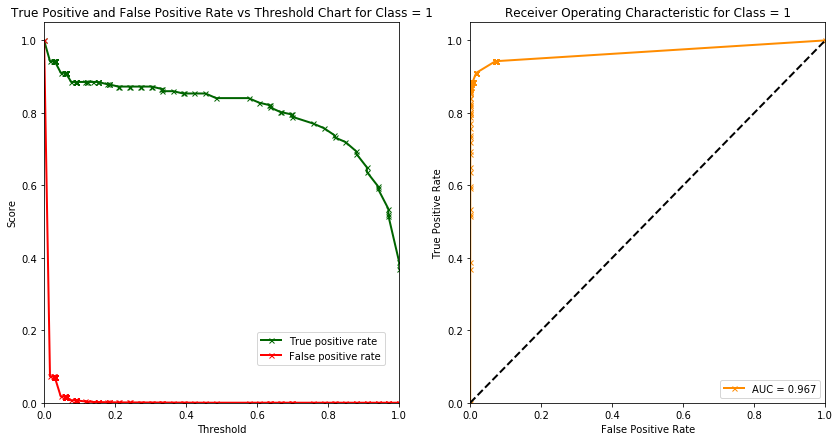

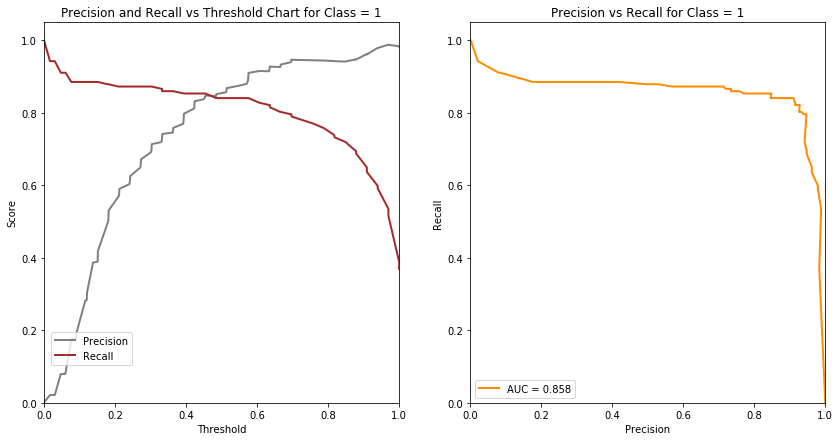

In [158]:
fpr, tpr, thresholds = roc_curve(y_true=y_test.values, y_score=forest_predictions_prob[:,1])#, pos_label=2)

roc_fig, roc_ax = plt.subplots(nrows=1, ncols=2, figsize=(14,7))

# true positives and false positives vs threshold
roc_ax[0].plot(thresholds, tpr, color='darkgreen', lw=2, marker='x', ms=5, label='True positive rate')
roc_ax[0].plot(thresholds, fpr, color='red', lw=2, marker='x', ms=5, label='False positive rate')
roc_ax[0].set_title("True Positive and False Positive Rate vs Threshold Chart for Class = 1")
roc_ax[0].set_xlim([0.0, 1.0])
roc_ax[0].set_ylim([0.0, 1.05])
roc_ax[0].set_xlabel('Threshold')
roc_ax[0].set_ylabel('Score')
roc_ax[0].legend(loc=(0.6, 0.1))

# roc curve
roc_auc = auc(fpr, tpr) # area under roc curve
roc_ax[1].plot(fpr, tpr, color='darkorange', lw=2, marker='x', ms=5, label='AUC = {0:.3f}'.format(roc_auc))
roc_ax[1].plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
roc_ax[1].set_title('Receiver Operating Characteristic for Class = 1')
roc_ax[1].set_xlim([0.0, 1.0])
roc_ax[1].set_ylim([0.0, 1.05])
roc_ax[1].set_xlabel('False Positive Rate')
roc_ax[1].set_ylabel('True Positive Rate')
roc_ax[1].legend(loc="lower right")


precision, recall, thresholds = precision_recall_curve(y_true=y_test.values, probas_pred=forest_predictions_prob[:,1]) 
print(len(precision), len(recall), len(thresholds))
#print(precision, recall, thresholds)

pr_fig, pr_ax = plt.subplots(nrows=1, ncols=2, figsize=(14,7))

# precision and recall vs threshold
pr_ax[0].plot(thresholds, precision[:-1], color='gray', lw=2, label='Precision')
pr_ax[0].plot(thresholds, recall[:-1], color='brown', lw=2, label='Recall')
pr_ax[0].set_title("Precision and Recall vs Threshold Chart for Class = 1")
pr_ax[0].set_xlim([0.0, 1.0])
pr_ax[0].set_ylim([0.0, 1.05])
pr_ax[0].set_xlabel('Threshold')
pr_ax[0].set_ylabel('Score')
pr_ax[0].legend(loc=(0.02, 0.1))

# precision-recall curve
pr_auc = auc(recall, precision) # area under pr curve
pr_ax[1].plot(precision, recall, color='darkorange', lw=2, label='AUC = {0:.3f}'.format(pr_auc))
pr_ax[1].set_title('Precision vs Recall for Class = 1')
pr_ax[1].set_xlim([0.0, 1.0])
pr_ax[1].set_ylim([0.0, 1.05])
pr_ax[1].set_xlabel('Precision')
pr_ax[1].set_ylabel('Recall')
pr_ax[1].legend(loc="lower left")


## Conclusions

A random forest of 33 trees and max depth of 30 performs well and significantly reduces the number of false positives.  From the above curves, a choice can be made on the threshold probability.  Since the company will want to pick as many fraudulent claims as possible, a lower threshold may be desirable (to maximise the recall).  This could be around 0.4 as the bottom left curve shows the recall is around 85% and a precision of 80%, which may be a fair trade off.

Other things that could be tried are more ML methods, and further feature selection.  Could take just the most important deatures correlated with response to reduce the amount of noise going into the calculation.  This could come via forward or backward passes (where one var is added or removed at a time - see ISLR book) or a principal component analysis and selecting the number of components that explain a god proportion of the variance.